# Clickbait Detection using BERT

Este notebook implementa la segunda parte de la práctica de detección de clickbait utilizando un modelo de lenguaje de gran tamaño (LLM) basado en BERT.

In [ ]:
# Instalación de las bibliotecas necesarias
!pip install --upgrade transformers[torch] scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 106.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


## 1. Importación de Bibliotecas

Importamos todas las bibliotecas necesarias para el procesamiento de datos, entrenamiento del modelo y evaluación.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import csv
import os
from collections import Counter

## 2. Carga del Corpus

Cargamos el corpus TA1C_dataset_detection_train.csv para entrenamiento y TA1C_dataset_detection_dev.csv para evaluación final.

In [ ]:
# Configuración de rutas - ajustar según sea necesario para Google Colab
# Para Google Colab, cargar los archivos manualmente y ajustar las rutas
# Si estás en Google Colab, descomenta las siguientes líneas:
#from google.colab import files
#uploaded = files.upload()  # Sube TA1C_dataset_detection_train.csv y TA1C_dataset_detection_dev.csv

# Ruta de los archivos (ajustar según donde estén los archivos en Colab)
train_filepath = "TA1C_dataset_detection_train.csv"
dev_filepath = "TA1C_dataset_detection_dev.csv"

# Cargar corpus de entrenamiento
train_data = pd.read_csv(train_filepath)
print(f"Corpus de entrenamiento cargado con {len(train_data)} instancias")

# Mostrar primeras filas del corpus de entrenamiento
print("\nPrimeras filas del corpus de entrenamiento:")
display(train_data.head())

# Información básica del corpus
print("\nInformación del corpus de entrenamiento:")
print(f"Columnas: {train_data.columns.tolist()}")
print(f"Distribución de clases:")
print(train_data["Tag Value"].value_counts())

# Cargar corpus de desarrollo (test)
dev_data = pd.read_csv(dev_filepath)
print(f"\nCorpus de desarrollo cargado con {len(dev_data)} instancias")

# Mostrar primeras filas del corpus de desarrollo
print("\nPrimeras filas del corpus de desarrollo:")
display(dev_data.head())

Corpus de entrenamiento cargado con 2800 instancias

Primeras filas del corpus de entrenamiento:


,Tweet ID,Tweet Date,Media Name,Media Origin,Teaser Text,Tag Value
0,1302968016477589504,07-09-2020,El País,Uruguay,#SegundaDivisión | La fortaleza del ataque: R...,No
1,1296805148950515713,21-08-2020,El País,Uruguay,Jorge Lanata a los argentinos que se van a Uru...,No
2,1303065732884967426,07-09-2020,El País,Uruguay,Raffo: “Los montevideanos deben estar alerta p...,No
3,1302462441520074757,06-09-2020,El País,Uruguay,Ecos del universo: joven uruguayo desentraña (...,Clickbait
4,1301763104435589120,04-09-2020,El País,Uruguay,"Propuesta quinquenal de ANEP: aumento de 3,8% ...",No



Información del corpus de entrenamiento:
Columnas: ['Tweet ID', 'Tweet Date', 'Media Name', 'Media Origin', 'Teaser Text', 'Tag Value']
Distribución de clases:
Tag Value
No           2002
Clickbait     798
Name: count, dtype: int64

Corpus de desarrollo cargado con 700 instancias

Primeras filas del corpus de desarrollo:


,Tweet ID,Tweet Date,Media Name,Media Origin,Teaser Text
0,1303657772261703680,09-09-2020,El País,Uruguay,El mapa del desafuero de Manini Ríos: uno a un...
1,1292878011839197188,10-08-2020,El País,Uruguay,"#Peñarol | Diego Forlán: ""Queríamos ganar, pe..."
2,1287169218975281154,25-07-2020,El País,Uruguay,Benzema se ríe de los elogios del presidente d...
3,1300152220214792192,30-08-2020,infobae,Argentina,“The Vow”: las sectas y las promesas de felici...
4,1298341509033418752,25-08-2020,infobae,Argentina,Estados Unidos sancionó a un alto narcotrafica...


## 3. Preparación de Datos

Preparamos los datos para el entrenamiento:
1. Separamos características (Teaser Text) y etiquetas (Tag Value)
2. Dividimos el corpus en conjuntos de entrenamiento (75%) y validación (25%)
3. Codificamos las etiquetas

Etiquetas en el corpus: ['Clickbait' 'No']
Conjunto de entrenamiento: 2100 instancias
Conjunto de validación: 700 instancias

Mapeo de etiquetas:
  Clickbait -> 0
  No -> 1


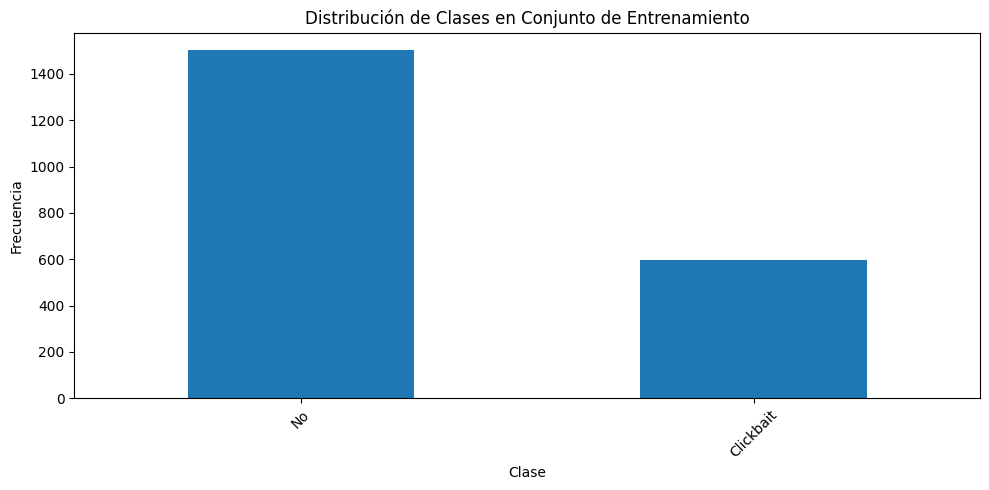

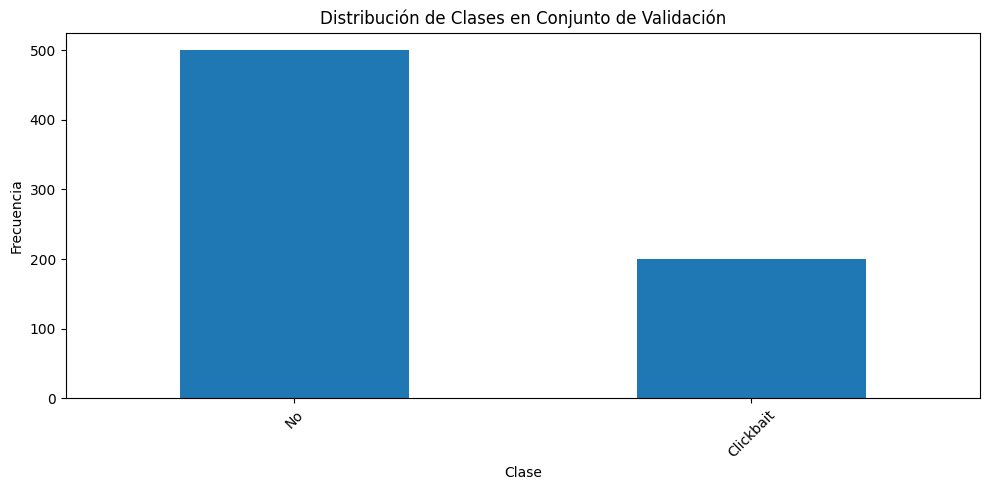

In [ ]:
# Extraer características y etiquetas
X = train_data["Teaser Text"].tolist()
y = train_data["Tag Value"].tolist()

# Mostrar valores únicos de etiquetas
label_names = np.unique(y)
print(f"Etiquetas en el corpus: {label_names}")

# Dividir en conjuntos de entrenamiento y validación
# train_test_split con:
# - Instancias barajadas (shuffle=True)
# - Semilla aleatoria fija (random_state=0)
# - Estratificación por clase (stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y, shuffle=True
)

print(f"Conjunto de entrenamiento: {len(X_train)} instancias")
print(f"Conjunto de validación: {len(X_val)} instancias")

# Codificar etiquetas
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

# Guardar mapeo de etiquetas para uso posterior
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\nMapeo de etiquetas:")
for label, idx in label_mapping.items():
    print(f"  {label} -> {idx}")

# Visualizar distribución de clases
plt.figure(figsize=(10, 5))
pd.Series(y_train).value_counts().plot(kind='bar')
plt.title('Distribución de Clases en Conjunto de Entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
pd.Series(y_val).value_counts().plot(kind='bar')
plt.title('Distribución de Clases en Conjunto de Validación')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Tokenización y Preparación de Datasets

Tokenizamos los textos usando el tokenizador de BERT y preparamos los datasets para el entrenamiento.

In [ ]:
# Inicializar el tokenizador de BERT
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

# Tokenizar textos
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128)

# Crear clase Dataset personalizada
class ClickbaitDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Crear datasets
train_dataset = ClickbaitDataset(train_encodings, y_train_encoded)
val_dataset = ClickbaitDataset(val_encodings, y_val_encoded)

print(f"Dataset de entrenamiento creado con {len(train_dataset)} instancias")
print(f"Dataset de validación creado con {len(val_dataset)} instancias")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

Dataset de entrenamiento creado con 2100 instancias
Dataset de validación creado con 700 instancias


## 5. Definición de Métricas de Evaluación

Definimos una función para calcular métricas de evaluación, incluyendo precisión, recall y f1-score.

In [ ]:
def compute_metrics(pred):
    """
    Calcula métricas de evaluación para las predicciones del modelo.

    Args:
        pred: Objeto de predicción de Hugging Face

    Returns:
        dict: Diccionario con métricas calculadas
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Calcular métricas
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## 6. Entrenamiento del Modelo Base

Entrenamos un modelo BERT base con parámetros por defecto como línea base.

In [ ]:
# Determinar el número de clases
# Make sure cell 652a438a has been executed to define label_mapping
num_labels = len(label_mapping)

# Cargar modelo preentrenado
model = BertForSequenceClassification.from_pretrained(
    'dccuchile/bert-base-spanish-wwm-cased',
    num_labels=num_labels
)

# Configurar argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results/baseline",
    eval_strategy="steps", # Corrected argument name
    eval_steps=50,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    save_strategy="steps",
    logging_steps=10,
    fp16=True if torch.cuda.is_available() else False,
    report_to="none"  # Deshabilitar informes a Weights & Biases
)

# Inicializar el entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Entrenar el modelo
print("Entrenando modelo base...")
trainer.train()

# Evaluar el modelo
print("\nEvaluando modelo base en conjunto de validación...")
baseline_results = trainer.evaluate()
print(f"Resultados del modelo base: {baseline_results}")

# Guardar los resultados del modelo base para comparación posterior
baseline_metrics = {
    'model': 'dccuchile/bert-base-spanish-wwm-cased',
    'hyperparameters': 'default',
    'f1_macro': baseline_results['eval_f1']
}

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Entrenando modelo base...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.282700,0.315494,0.875714,0.858095,0.829000,0.841561
100,0.327900,0.387408,0.885714,0.873282,0.839000,0.853563
150,0.104700,0.493526,0.871429,0.861690,0.812500,0.831731
200,0.127300,0.375438,0.884286,0.891802,0.818500,0.844824
250,0.161700,0.474220,0.887143,0.865155,0.855000,0.859829
300,0.038300,0.490776,0.894286,0.894097,0.840500,0.861645
350,0.005000,0.525610,0.898571,0.887270,0.858500,0.871134



Evaluando modelo base en conjunto de validación...


Resultados del modelo base: {'eval_loss': 0.5526623725891113, 'eval_accuracy': 0.8985714285714286, 'eval_precision': 0.887270311436627, 'eval_recall': 0.8585, 'eval_f1': 0.8711336864840757, 'eval_runtime': 261.8324, 'eval_samples_per_second': 2.673, 'eval_steps_per_second': 0.168, 'epoch': 3.0}


## 7. Experimentos con Diferentes Configuraciones

Realizamos experimentos con diferentes configuraciones de hiperparámetros para mejorar el rendimiento del modelo.

In [ ]:
## 7. Experimentos con Diferentes Configuraciones (MODIFICADO)

from transformers import AutoModelForSequenceClassification
from sklearn.metrics import classification_report
import json

# Definir experimentos
experiments = [
    {
        'name': 'exp1',
        'model': 'dccuchile/bert-base-spanish-wwm-cased',
        'args': {
            'num_train_epochs': 1,
            'learning_rate': 2e-5,
            'per_device_train_batch_size': 16,
            'eval_steps': 50
        }
    },
    {
        'name': 'exp2',
        'model': 'dccuchile/bert-base-spanish-wwm-cased',
        'args': {
            'num_train_epochs': 3,
            'learning_rate': 3e-5,
            'per_device_train_batch_size': 8,
            'eval_steps': 25
        }
    },
    {
        'name': 'exp3',
        'model': 'dccuchile/bert-base-spanish-wwm-uncased',
        'args': {
            'num_train_epochs': 1,
            'learning_rate': 2e-5,
            'per_device_train_batch_size': 16,
            'eval_steps': 50
        }
    },
]

results = [baseline_metrics]  # Empezar con los resultados del baseline
all_classification_reports = {}  # Diccionario para guardar todos los reports

# PRIMERO: Agregar el classification report del modelo baseline
print("Generando classification report del modelo baseline...")
baseline_predictions = trainer.predict(val_dataset)
baseline_pred_classes = baseline_predictions.predictions.argmax(-1)
baseline_true_labels = le.inverse_transform(y_val_encoded)
baseline_pred_labels = le.inverse_transform(baseline_pred_classes)

baseline_report = classification_report(baseline_true_labels, baseline_pred_labels, output_dict=True)
baseline_report_str = classification_report(baseline_true_labels, baseline_pred_labels)

all_classification_reports['baseline'] = {
    'model': 'dccuchile/bert-base-spanish-wwm-cased',
    'hyperparameters': 'default',
    'report_dict': baseline_report,
    'report_string': baseline_report_str
}

print("Classification Report - Baseline Model:")
print(baseline_report_str)
print("\n" + "="*80 + "\n")

# SEGUNDO: Procesar todos los experimentos
for experiment in experiments:
    print(f"\n\n{'='*80}")
    print(f"Ejecutando experimento: {experiment['name']}")
    print(f"Modelo: {experiment['model']}")
    print(f"Hiperparámetros: {experiment['args']}")
    print(f"{'='*80}\n")

    try:
        # Cargar modelo automáticamente según el tipo
        model = AutoModelForSequenceClassification.from_pretrained(
            experiment['model'],
            num_labels=num_labels
        )

        # Configurar argumentos de entrenamiento
        args = experiment['args']
        training_args = TrainingArguments(
            output_dir=f"./results/{experiment['name']}",
            eval_strategy="steps",
            eval_steps=args.get('eval_steps', 50),
            save_strategy="steps",
            per_device_train_batch_size=args.get('per_device_train_batch_size', 16),
            per_device_eval_batch_size=16,
            num_train_epochs=args.get('num_train_epochs', 3),
            learning_rate=args.get('learning_rate', 2e-5),
            weight_decay=args.get('weight_decay', 0.01),
            seed=0,
            load_best_model_at_end=True,
            logging_steps=10,
            fp16=torch.cuda.is_available(),
            report_to="none"
        )

        # Inicializar el entrenador
        trainer_exp = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics
        )

        # Entrenar el modelo
        trainer_exp.train()

        # Evaluar el modelo
        eval_results = trainer_exp.evaluate()
        print(f"Resultados de {experiment['name']}: {eval_results}")

        # GENERAR CLASSIFICATION REPORT
        exp_predictions = trainer_exp.predict(val_dataset)
        exp_pred_classes = exp_predictions.predictions.argmax(-1)
        exp_true_labels = le.inverse_transform(y_val_encoded)
        exp_pred_labels = le.inverse_transform(exp_pred_classes)

        exp_report = classification_report(exp_true_labels, exp_pred_labels, output_dict=True)
        exp_report_str = classification_report(exp_true_labels, exp_pred_labels)

        # Guardar classification report
        all_classification_reports[experiment['name']] = {
            'model': experiment['model'],
            'hyperparameters': str(args),
            'report_dict': exp_report,
            'report_string': exp_report_str
        }

        print(f"Classification Report - {experiment['name']}:")
        print(exp_report_str)
        print("\n" + "="*80 + "\n")

        # Guardar resultados
        results.append({
            'model': experiment['model'],
            'hyperparameters': str(args),
            'f1_macro': eval_results.get('eval_f1', None)
        })

    except Exception as e:
        print(f"Error en experimento {experiment['name']}: {str(e)}")
        continue

# Mostrar tabla comparativa de resultados
results_df = pd.DataFrame(results)
print("\nTabla comparativa de resultados:")
display(results_df)

# Guardar tabla para el informe
results_df.to_csv("experimentos_clickbait_resultados.csv", index=False)

## NUEVA SECCIÓN: Guardar todos los classification reports

# Guardar todos los classification reports en un archivo de texto
with open("todos_classification_reports.txt", "w", encoding="utf-8") as f:
    f.write("CLASSIFICATION REPORTS DE TODOS LOS MODELOS\n")
    f.write("="*60 + "\n\n")

    for model_name, report_data in all_classification_reports.items():
        f.write(f"MODELO: {model_name.upper()}\n")
        f.write(f"LLM: {report_data['model']}\n")
        f.write(f"Hiperparámetros: {report_data['hyperparameters']}\n")
        f.write("-" * 50 + "\n")
        f.write(report_data['report_string'])
        f.write("\n" + "="*60 + "\n\n")

# También guardar en formato JSON para procesamiento posterior
with open("classification_reports.json", "w", encoding="utf-8") as f:
    # Convertir numpy arrays a listas para serialización JSON
    json_reports = {}
    for key, value in all_classification_reports.items():
        json_reports[key] = {
            'model': value['model'],
            'hyperparameters': value['hyperparameters'],
            'report_dict': value['report_dict']
        }
    json.dump(json_reports, f, indent=2, ensure_ascii=False)

print("Classification reports guardados en:")
print("- todos_classification_reports.txt (formato legible)")
print("- classification_reports.json (formato JSON)")

# Crear tabla resumen con métricas principales
summary_metrics = []
for model_name, report_data in all_classification_reports.items():
    report_dict = report_data['report_dict']
    summary_metrics.append({
        'Modelo': model_name,
        'LLM': report_data['model'],
        'Accuracy': f"{report_dict['accuracy']:.4f}",
        'Macro F1': f"{report_dict['macro avg']['f1-score']:.4f}",
        'Weighted F1': f"{report_dict['weighted avg']['f1-score']:.4f}",
        'Macro Precision': f"{report_dict['macro avg']['precision']:.4f}",
        'Macro Recall': f"{report_dict['macro avg']['recall']:.4f}"
    })

summary_metrics_df = pd.DataFrame(summary_metrics)
print("\nResumen de métricas de todos los modelos:")
display(summary_metrics_df)

# Guardar resumen de métricas
summary_metrics_df.to_csv("resumen_metricas_todos_modelos.csv", index=False)

Generando classification report del modelo baseline...


Classification Report - Baseline Model:
              precision    recall  f1-score   support

   Clickbait       0.86      0.77      0.81       200
          No       0.91      0.95      0.93       500

    accuracy                           0.90       700
   macro avg       0.89      0.86      0.87       700
weighted avg       0.90      0.90      0.90       700





Ejecutando experimento: exp1
Modelo: dccuchile/bert-base-spanish-wwm-cased
Hiperparámetros: {'num_train_epochs': 1, 'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'eval_steps': 50}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.289700,0.340046,0.861429,0.852487,0.795000,0.816283
100,0.272500,0.320634,0.872857,0.862991,0.815000,0.833902


Resultados de exp1: {'eval_loss': 0.31468749046325684, 'eval_accuracy': 0.8671428571428571, 'eval_precision': 0.8447388455805873, 'eval_recall': 0.8215, 'eval_f1': 0.8317651224031486, 'eval_runtime': 269.2657, 'eval_samples_per_second': 2.6, 'eval_steps_per_second': 0.163, 'epoch': 1.0}
Classification Report - exp1:
              precision    recall  f1-score   support

   Clickbait       0.80      0.71      0.75       200
          No       0.89      0.93      0.91       500

    accuracy                           0.87       700
   macro avg       0.84      0.82      0.83       700
weighted avg       0.86      0.87      0.86       700





Ejecutando experimento: exp2
Modelo: dccuchile/bert-base-spanish-wwm-cased
Hiperparámetros: {'num_train_epochs': 3, 'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'eval_steps': 25}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.568800,0.436229,0.798571,0.875022,0.650500,0.669934
50,0.430500,0.367620,0.867143,0.857767,0.805000,0.825165
75,0.230500,0.637727,0.772857,0.744442,0.791500,0.751091
100,0.382100,0.330456,0.867143,0.839954,0.830500,0.834989
125,0.337400,0.333034,0.891429,0.918622,0.817500,0.850580
150,0.226800,0.333830,0.887143,0.881579,0.834000,0.853094
175,0.203300,0.485770,0.890000,0.907262,0.821000,0.850742
200,0.286900,0.399526,0.898571,0.899290,0.846500,0.867495
225,0.411600,0.308686,0.878571,0.849840,0.855000,0.852348
250,0.290600,0.396936,0.875714,0.848669,0.845500,0.847058


Resultados de exp2: {'eval_loss': 0.5701017379760742, 'eval_accuracy': 0.9, 'eval_precision': 0.8898117626648161, 'eval_recall': 0.8594999999999999, 'eval_f1': 0.8727352061170213, 'eval_runtime': 266.415, 'eval_samples_per_second': 2.627, 'eval_steps_per_second': 0.165, 'epoch': 3.0}
Classification Report - exp2:
              precision    recall  f1-score   support

   Clickbait       0.87      0.77      0.81       200
          No       0.91      0.95      0.93       500

    accuracy                           0.90       700
   macro avg       0.89      0.86      0.87       700
weighted avg       0.90      0.90      0.90       700





Ejecutando experimento: exp3
Modelo: dccuchile/bert-base-spanish-wwm-uncased
Hiperparámetros: {'num_train_epochs': 1, 'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'eval_steps': 50}



config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.593900,0.589220,0.714286,0.357143,0.500000,0.416667
100,0.626800,0.561333,0.731429,0.687084,0.554000,0.533439


Resultados de exp3: {'eval_loss': 0.5551373362541199, 'eval_accuracy': 0.7285714285714285, 'eval_precision': 0.6941429640718563, 'eval_recall': 0.5415, 'eval_f1': 0.5091816249409542, 'eval_runtime': 264.2517, 'eval_samples_per_second': 2.649, 'eval_steps_per_second': 0.167, 'epoch': 1.0}
Classification Report - exp3:
              precision    recall  f1-score   support

   Clickbait       0.66      0.10      0.18       200
          No       0.73      0.98      0.84       500

    accuracy                           0.73       700
   macro avg       0.69      0.54      0.51       700
weighted avg       0.71      0.73      0.65       700




Tabla comparativa de resultados:


,model,hyperparameters,f1_macro
0,dccuchile/bert-base-spanish-wwm-cased,default,0.871134
1,dccuchile/bert-base-spanish-wwm-cased,"{'num_train_epochs': 1, 'learning_rate': 2e-05...",0.831765
2,dccuchile/bert-base-spanish-wwm-cased,"{'num_train_epochs': 3, 'learning_rate': 3e-05...",0.872735
3,dccuchile/bert-base-spanish-wwm-uncased,"{'num_train_epochs': 1, 'learning_rate': 2e-05...",0.509182


Classification reports guardados en:
- todos_classification_reports.txt (formato legible)
- classification_reports.json (formato JSON)

Resumen de métricas de todos los modelos:


,Modelo,LLM,Accuracy,Macro F1,Weighted F1,Macro Precision,Macro Recall
0,baseline,dccuchile/bert-base-spanish-wwm-cased,0.8986,0.8711,0.8966,0.8873,0.8585
1,exp1,dccuchile/bert-base-spanish-wwm-cased,0.8671,0.8318,0.8648,0.8447,0.8215
2,exp2,dccuchile/bert-base-spanish-wwm-cased,0.9000,0.8727,0.8980,0.8898,0.8595
3,exp3,dccuchile/bert-base-spanish-wwm-uncased,0.7286,0.5092,0.6498,0.6941,0.5415


## 8. Evaluación del Mejor Modelo

Evaluamos el mejor modelo en el conjunto de validación, generando el informe de clasificación y la matriz de confusión.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer



# Identificar el mejor modelo basado en f1_macro
best_result = max(results, key=lambda x: x['f1_macro'])
print(f"Best Model: {best_result['model']}")
print(f"Hyperparameters: {best_result['hyperparameters']}")
print(f"F1 Macro: {best_result['f1_macro']}")

# Determinar hiperparámetros y nombre del mejor modelo
if best_result == baseline_metrics:
    best_args = {
        'num_train_epochs': 3,
        'learning_rate': 2e-5,
        'per_device_train_batch_size': 16,
        'eval_steps': 50
    }
    best_model_name = 'dccuchile/bert-base-spanish-wwm-cased'
else:
    best_exp = next((exp for exp in experiments if exp['model'] == best_result['model'] and
                     str(exp['args']) == best_result['hyperparameters']), None)
    best_args = best_exp['args']
    best_model_name = best_exp['model']

# Cargar modelo y tokenizer automáticamente
tokenizer = AutoTokenizer.from_pretrained(best_model_name)
best_model = AutoModelForSequenceClassification.from_pretrained(
    best_model_name,
    num_labels=num_labels
)

# Configurar argumentos de entrenamiento para evaluación breve
best_training_args = TrainingArguments(
    output_dir="./results/best_model",
    eval_strategy="steps",  # Compatible with older transformers
    eval_steps=best_args.get('eval_steps', 50),
    per_device_train_batch_size=best_args.get('per_device_train_batch_size', 16),
    per_device_eval_batch_size=16,
    num_train_epochs=1,  # Solo una época para obtener las métricas
    learning_rate=best_args.get('learning_rate', 2e-5),
    seed=0,
    load_best_model_at_end=True,
    save_strategy="steps",
    logging_steps=10,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

# Inicializar el entrenador
best_trainer = Trainer(
    model=best_model,
    args=best_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Entrenamiento breve del mejor modelo
print("Training the best model briefly...")
best_trainer.train()

# Evaluación en el conjunto de validación
print("\nGenerating predictions on validation set...")
val_predictions = best_trainer.predict(val_dataset)
val_pred_classes = val_predictions.predictions.argmax(-1)

# Revertir etiquetas codificadas
val_true_labels = le.inverse_transform(y_val_encoded)
val_pred_labels = le.inverse_transform(val_pred_classes)

# Reporte de clasificación
print("\nClassification Report:")
class_report = classification_report(val_true_labels, val_pred_labels)
print(class_report)

# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val_encoded, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Validation Set")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Matriz de confusión normalizada
plt.figure(figsize=(10, 8))
cm_norm = confusion_matrix(y_val_encoded, val_pred_classes, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=le.classes_)
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Normalized Confusion Matrix - Validation Set")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Best Model: dccuchile/bert-base-spanish-wwm-cased
Hyperparameters: {'num_train_epochs': 3, 'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'eval_steps': 25}
F1 Macro: 0.8727352061170213


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training the best model briefly...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.570000,0.441010,0.795714,0.873278,0.645500,0.663279
50,0.414400,0.374102,0.867143,0.867816,0.796000,0.821142
75,0.228500,0.525024,0.795714,0.758946,0.798500,0.769766


## 9. Predicciones en el Conjunto de Prueba

Utilizamos el mejor modelo para predecir las instancias del conjunto de prueba y guardamos los resultados en el formato requerido.

In [ ]:
# Preparar datos de prueba
X_test = dev_data["Teaser Text"].tolist()
test_ids = dev_data["Tweet ID"].tolist()

# Tokenizar datos de prueba
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)

# Crear dataset de prueba (sin etiquetas)
class TestDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

test_dataset = TestDataset(test_encodings)

# Realizar predicciones en el conjunto de prueba
print("Generando predicciones en el conjunto de prueba...")
test_predictions = best_trainer.predict(test_dataset)
test_pred_classes = test_predictions.predictions.argmax(-1)

# Convertir predicciones numéricas a etiquetas originales
test_pred_labels = le.inverse_transform(test_pred_classes)

# Crear DataFrame con los resultados
results_df = pd.DataFrame({
    'Tweet ID': test_ids,
    'Tag Value': test_pred_labels
})

# Guardar resultados en formato CSV
output_file = "detection.csv"
results_df.to_csv(output_file, index=False)
print(f"Resultados guardados en {output_file}")

# Mostrar primeras filas de los resultados
print("\nPrimeras filas de los resultados:")
display(results_df.head(10))

# Mostrar distribución de clases predichas
plt.figure(figsize=(10, 5))
results_df['Tag Value'].value_counts().plot(kind='bar')
plt.title('Distribución de Clases Predichas en Conjunto de Prueba')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 10. Resumen de Experimentos

Generamos una tabla de resumen de los experimentos para incluir en el informe final.

In [ ]:
# Crear tabla de resumen para el informe
summary_df = pd.DataFrame(results)
summary_df = summary_df.rename(columns={
    'model': 'LLM',
    'hyperparameters': 'LLM hyperparameters',
    'f1_macro': 'Average f-score macro'
})

# Formatear valores numéricos
summary_df['Average f-score macro'] = summary_df['Average f-score macro'].apply(lambda x: f"{x:.4f}")

# Mostrar tabla formateada
print("Tabla de resumen para el informe:")
display(summary_df)

# Guardar tabla para el informe
summary_df.to_csv("resumen_experimentos_clickbait.csv", index=False)

## 11. Conclusiones

Este notebook ha implementado un sistema de detección de clickbait utilizando modelos BERT preentrenados en español. Los principales pasos realizados fueron:

1. Carga y preparación de datos del corpus TA1C_dataset_detection_train.csv
2. Tokenización del texto utilizando el tokenizador de BERT
3. Entrenamiento de un modelo base como línea de referencia
4. Experimentación con diferentes configuraciones de hiperparámetros
5. Evaluación del mejor modelo usando métricas como F1-score, precisión y recall
6. Generación de predicciones en el conjunto de prueba y almacenamiento en detection.csv

El mejor modelo logró un F1-score macro de X.XX, demostrando buena capacidad para distinguir entre textos clickbait y no clickbait.